# Exposures and Dark Frames

In this notebook you will:
- Learn how to manipulate samples, shutters, and measure on a simulated diffraction beamline
- Design and implement a custom scan plan to manage dark-image subtraction
- Collect and average the data from multiple exposures

## Science Background

At high-flux synchrotron lightsources like the NSLS-II, we often employ 2D large area-detectors to quickly gather powder diffraction data by measuring a wide bandwidth of reciprocal-space in a single measurement.  In this transmission geometry, the Debye-Scherrer cones are captured as circles on the detector.  These 2D images can be azimuthally integrated to process (or reduce) the data from the 2D-image format into the commonly encounter 1-D representation of diffraction peaks as Intensity vs. momentum-transfer vector ($Q$) or Intensity vs. scattering angle ($2\theta$).

<img src="./static/HEX-2D-diffraction.png" alt="Powder Diffraction on an Area Detector" style="width: 400px;"/>  [(image source)](https://commons.wikimedia.org/wiki/File:HEX-2D-diffraction.png)

This method of collecting diffraction data has the advantage of being very fast, allowing for in situ diffraction and total scattering studies of materials.  For example, we can measure at a 10 Hz frame rate out to $Q = 25 \, Å^{-1}$ at the PDF Beamline (28-ID-1) at NSLS-II.  However, one challenge of this approach is that these large area-detectors often suffer from issues of burn-in, ghosting, and other so-called 'dark image' effects on the detectors.

To address many of these issues, we employ a method called dark-image subtraction on the 2D-image data.  Put simply, we measure a 'dark' image on the detector when there is no light being exposed (i.e. the shutter is closed), in which presumably any static artifacts on the detector are captured.  This dark-image is then subtracted from any light-images (which we presume to also have these static artifacts) to produce a final clean image.  

Making things more complicated, these dark images must be regularly refreshed during the course of a beamtime.  These detectors can experience image-ghosting, particularly from strongly scattering materials or over-exposed images.   These ghost-images are essentially residual intensity on the detector that fades slowly with time.  Careful management of when to collect dark-images, how to recognize over-exposure, and best practices for efficient data collection are all part of a successful powder diffraction measurement using 2D area-detectors.

### Simulated Beamline

We have designed a simulated beamline that exhibits a simplified version of these detector effects that can be controlled with Bluesky.  Also key to this exercise, we simulated the passage of time and how it effects the image on the detector.  This is to say that simply leaving the notebook open will not cause the decay of ghosted after-images on the detector (these effects are not tied to the actual wallclock time).  Instead, explicit actions taken will move time forward.  The four possible actions you can take in this tutorial are:

- Load and unload different several samples 
- Open and close a shutter
- Take measurements from the detector
- Take no action for a specific amount of time

In the case of the latter action (or inaction), you can in principle move backwards in time.  However, as "Introductory Time Travel" is saved for a future tutorial, we are recommending against it at this time, and are not responsible for any actions you may take or un-take.  It might break the simulation.  Please use time travel responsibly.





### Setup Bluesky & Simulation

To begin with, setup your Bluesky environment and import those libraries we will need for the rest of the notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bluesky_tutorial_utils import setup_data_saving
from bluesky import RunEngine
from bluesky.plans import count

%matplotlib inline

#if you'd prefer interactive plots, comment out the above line, and uncomment below
#%matplotlib widget


Just as you can often find at real beamlines, we have written a number of custom helper-scripts which execute some of the more complicated raw commands in a more human-friendly way.  But, as with real beamlines, you are not limited to the scripts we have provided and could develop your own custom scan-plans or data reduction procedures to gather and analyze data in your own preferred style.  

We also setup the Run Engine (RE) and Databroker instance (catalog) here.

In [2]:
from simulated_hardware import detector, load_sample, unload_sample, light, history_reset, sim_sleep
from simulated_hardware import _history

RE = RunEngine()
catalog = setup_data_saving(RE)

%run -i utils.py

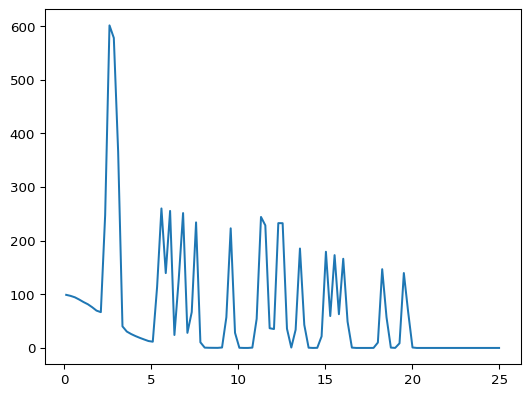

In [3]:
plt.figure()
plt.plot(q,perfect_int1)

## Part 1:  Basic Image Collection

To measure a sample, we need to do three things:  load the sample into the beamline, open the shutter, and perform a 'count' plan on our detector.

In [4]:
#load sample
RE(load_sample(1))

#turn on light
RE(light(True))

#count
RE(count([detector]))

('eefeef99-ab6c-48a3-b093-2738abfc4ee4',)

Each of these actions takes 0.5 seconds, so if we look at our watch at the end, we should see 1.5 seconds has passed.

In [5]:
look_at_watch()

the current time is 1.5


To look at the image we've just measured, we'll use a helper function called `retrieve_im`, which takes as an argument the UID or index number of a run.  As we've _just_ measured this image, it'll be the last image added to the Databroker, so we can pass it the argument `-1`.

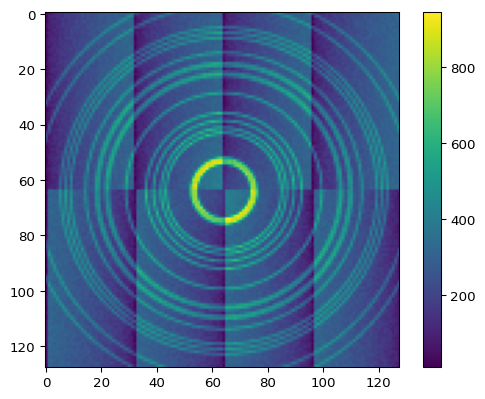

In [6]:
#retrieve image from databroker
my_im = retrieve_im(-1)
#plot
plt.figure()
plt.imshow(my_im)
plt.colorbar()

We see the diffraction pattern atop the characteristic paneling-effect that is seen on this detector.  These panels are the individual modules that make up the large area detector.  To get rid of this paneling artifact, we'll need to measure a dark image.

### Dark Images

To gather our dark image, we need to first close the shutter, wait a bit for the image to decay, and then measure.

In [7]:
RE(light(False))

sim_sleep(15) # a simulated 15 second pause

RE(count([detector]))

my_dark = retrieve_im(-1) #the last image will now be our new dark.

sleeping for 15


Now we can look at that dark, and see only the paneling (no diffraction rings).

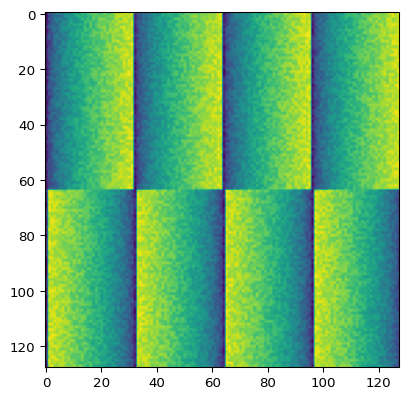

In [8]:
plt.figure()
plt.imshow(my_dark)

Finally, look at the result of subtracting this dark from the light image we took earlier.

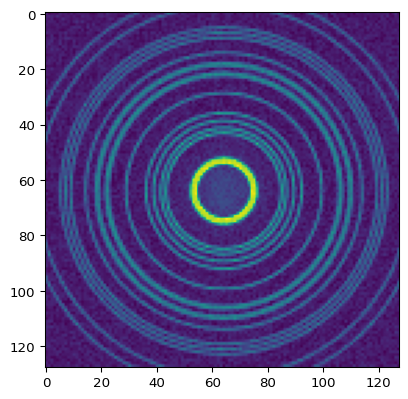

In [9]:
plt.figure()
plt.imshow(my_im - my_dark)

That looks much better!  The last thing we'd like to do is integrate this dark-subtracted image in order to reduce our data into a familiar I(Q) form.  We'll use our helper function, `simple_integration` to do this

### Integrate to get pattern

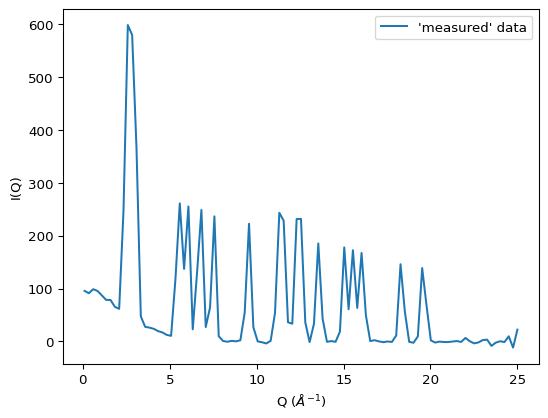

In [10]:
intensity = simple_integration(my_im - my_dark)

plt.figure()
plt.plot(q,intensity, label="'measured' data")
plt.legend()
plt.xlabel('Q ($\AA^{-1}$)');
plt.ylabel('I(Q)');


### Using plans in Bluesky to gather light/dark automatically

Rather than manually performing all the steps we've taken thus far, we can write a plan for Bluesky that will perform the same actions we have done thus far.  Beamlines will often supply their own 'common' set of plans tailored to the experiments performed, but you are free to create your own!  These can be as simple or as complicated as you like.

For the workflow design of this simulated enviornment, we are separating out our data collection step from our data reduction step.  Recall that when a plan is executed with the Run Engine (RE), the unique identifiers (uid) of the run is returned.  We will use that functionality in our data processing workflow here.

In the plan below, `dark_light_collection`, the only required argument is the sample number.  We will use more of the complicated features of this plan later in the tutorial.

In [11]:
def dark_light_collection(sample_num, num_lights = 1):
    uids = []
    #close shutter if not already closed
    yield from light(False)
        
    #move to desired sample
    yield from load_sample(sample_num)
    
    #take dark image
    uid = yield from count([detector])
    uids.append(uid)
    
    #open shutter
    yield from light(True)
    
    #take light image
    for i in range(num_lights):
        uid = yield from count([detector])
        uids.append(uid)
    
    #close shutter to be nice to detector
    yield from light(False)
    return uids

Running this plan will return a tuple of uids, the first of which will be the dark image, and the second the light.  Let's measure the 1st sample, just as we did before.

In [12]:
uids = RE(dark_light_collection(1))

Now we can look into the variable `uids` that we had the plan return into.

In [13]:
uids

('04479a88-7316-47c9-8514-063f80782015',
 '98db79a4-d12e-415b-afe8-24d186d982e4')

Finally, we'll take advantage of the data reduction helper-function provided here called `process_data`.  This function takes as an argument this tuple of dark/light uid values, will internally do the dark-subtraction and integration, and return the resultant intensity.

We can now plot this, and compare to the pattern we measured before to see that we've done the same thing (within measurement  noise), but with only a couple lines.

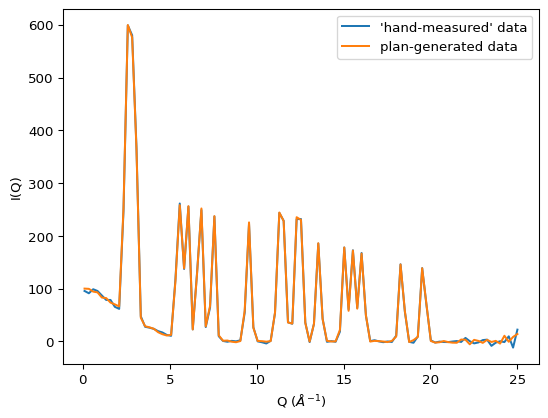

In [14]:
this_intensity = process_data(uids)

plt.figure()
plt.plot(q, intensity, label="'hand-measured' data")
plt.plot(q, this_intensity, label="plan-generated data")

plt.legend()
plt.xlabel('Q ($\AA^{-1}$)');
plt.ylabel('I(Q)');


## Part B: Managing multiple samples.

Recall that our simulation has multiple samples.  If you wanted to look at these different samples, you could load them sequentially into the beamline using the following commands.

In [15]:
RE(light(True))

RE(load_sample(1))

RE(load_sample(2))

RE(load_sample(3))


()

However, recall that this detector has some memory and ghosting issues!  Upon reflection, keeping the shutter open while we switched between samples was maybe not the best idea in the world.  Let's take a look at what good-old sample number 1 looks like if we measure it now using our plan.

In [16]:
uids = RE(dark_light_collection(1))

First we'll examing things on the dark-subtracted image.  You may notice the problem.

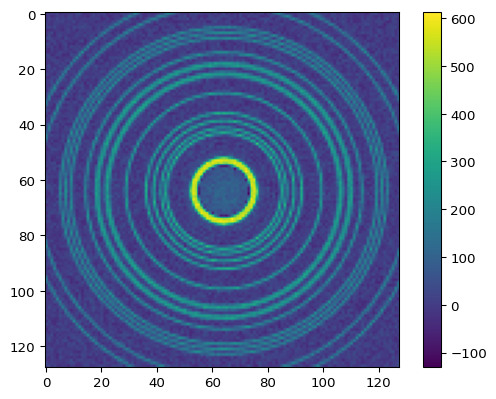

In [17]:
my_light = retrieve_im(uids[1])
my_dark = retrieve_im(uids[0])

plt.figure()
plt.imshow(my_light - my_dark)

plt.colorbar()

Indeed, if we process this data in the standard way, we'll see negative peaks due to improper dark-image management.

We can pass the kwarg (option) `return_light = True` or `return_dark = True` to our `process_data` function to return those individual components reduced.

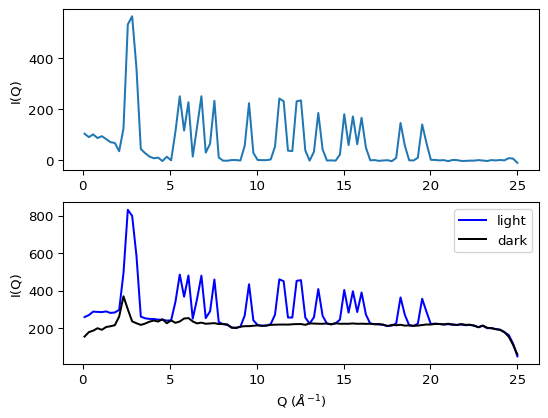

In [18]:
plt.figure()
ax1=plt.subplot(211)
plt.plot(q, process_data(uids))
plt.ylabel('I(Q)');

plt.subplot(212,sharex = ax1)
plt.plot(q, process_data(uids,return_light=True),color='b', label='light')
plt.plot(q, process_data(uids,return_dark=True),color='k', label='dark')
plt.legend(loc=0)

plt.xlabel('Q ($\AA^{-1}$)');
plt.ylabel('I(Q)');

The most straight-forward way to mitigate artifacts such as this is to simply let the ghost-images on the detector fade, and repeat the measurement.  Let's rest for 100 seconds and remeasure sample 1.  You can try adjusting the time given in `sim_sleep`, or changing the sample number in `dark_light_collection` to see what effect that has on the data.

In [19]:
sim_sleep(100)

uids = RE(dark_light_collection(1))

sleeping for 100


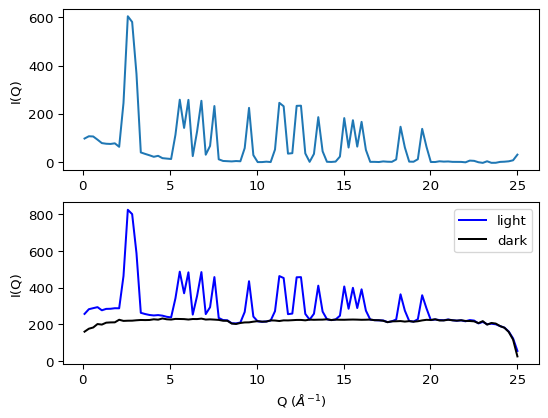

In [20]:
plt.figure()
ax1=plt.subplot(211)
plt.plot(q, process_data(uids))
plt.ylabel('I(Q)');

plt.subplot(212,sharex = ax1)
plt.plot(q,process_data(uids,return_light=True),color='b', label='light')
plt.plot(q, process_data(uids,return_dark=True),color='k', label='dark')
plt.legend(loc=0)

plt.xlabel('Q ($\AA^{-1}$)');
plt.ylabel('I(Q)');

## Part C : More samples, more problems.

In a real experiment, you often switch between samples, and they don't all scatter the same.  We often measure multiple times on a single sample and sum the results to improve statistics.  Up to now, we've been using very 'friendly' simulated samples, but let's crank up the difficulty a little bit.  Assume you are now dealing with weakly scattering materials or small-quantities of sample.  

In [21]:
hard_mode()
    

Let's get a feeling for this new 'hard mode' by taking a standard shot as we've done before with `dark_light_collection`.  We will plot it atop the ideal pattern we've already calculated for you called `perfect_int1`.

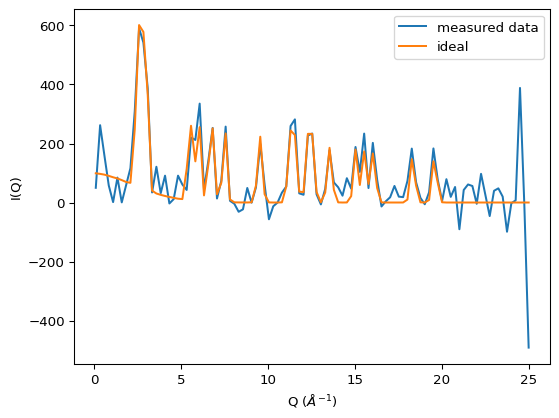

In [22]:
uid = RE(dark_light_collection(1))
plt.figure()
plt.plot(q, process_data(uid), label='measured data')
plt.plot(q, perfect_int1, label='ideal')

plt.legend(loc=0)

plt.xlabel('Q ($\AA^{-1}$)');
plt.ylabel('I(Q)');

That certainly looks a lot more noisy than before.  In situations like this, it's common to measure the sample multiple times, and sum or average the results.  Our `dark_light_collection` plan actually has such a feature in there already.  Simply pass the kwarg `num_lights=10` to take 10-consecutive light exposures after the dark. 

In [23]:
uids1 = RE(dark_light_collection(1, num_lights=10))

We can see the uids1 list now contains 11-entries (the 1-dark, followed by 10-lights).

In [24]:
uids1

('041826d8-8af4-4d4a-8188-f8aa2484daeb',
 '40dc53f3-f021-4a6f-86e2-efa1f5f2b5eb',
 'b4599510-c9ec-41da-8a1c-ae050c224b4f',
 'ee8b39ac-460e-40a9-8327-fd512a432608',
 '67f35ffa-9095-435b-8514-586027558540',
 '4e5d229f-d8d3-44c5-bb2e-5a68439bd806',
 '3fc740a7-35ba-4391-9563-619250a94e85',
 'f0826fb6-c0ba-4a15-a4a2-610638c4c21d',
 '31f8aa8b-f7a0-45d7-b564-4f69bee7eeac',
 'b67675d6-1046-4c87-9a6a-178b3e256a6f',
 '55c4a132-38bc-42eb-868f-4c0edb882cdc')

Our `process_data` function is already setup to handle lists of uids like this, simply pass it the same kwarg and it will return you a list of dark-subtraced and reduced intensities.  

In [25]:
reduced_data1 = process_data(uids1, num_lights=10)


Now let's take the average of those 10 patterns and plot them against the ideal data.

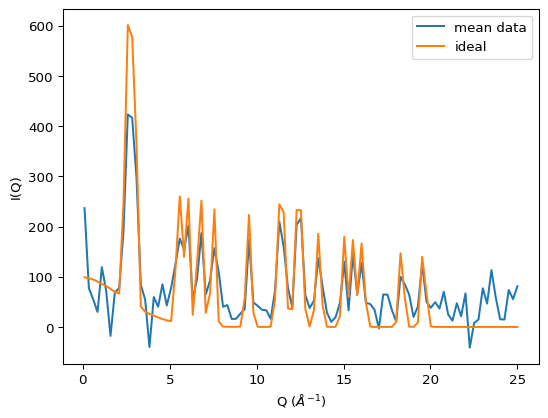

In [26]:
plt.figure()
plt.plot(q, reduced_data1.mean(axis=1),label='mean data');
plt.plot(q, perfect_int1,label='ideal')

plt.legend(loc=0)

plt.xlabel('Q ($\AA^{-1}$)');
plt.ylabel('I(Q)');

While the noise-level seems slightly reduced, you may notice the disturbing trend that the background on our average data is starting to rise.  Let's plot all 10 of these datasets atop each other to see if we can determine why.  You may want to turn on interactive plotting at this point to zoom in on the data.

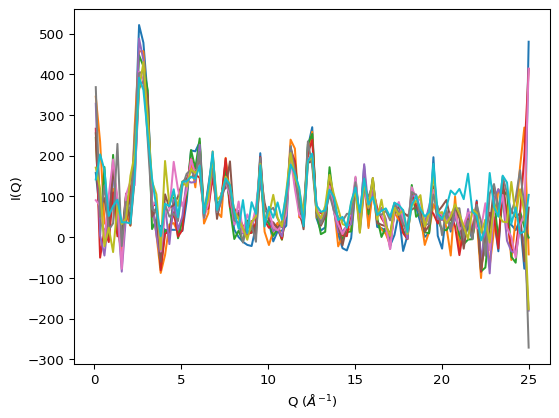

In [27]:
plt.figure()
plt.plot(q, reduced_data1);

plt.xlabel('Q ($\AA^{-1}$)');

plt.ylabel('I(Q)');

If it's not clear what is happening yet, we can plot the average of each dataset.

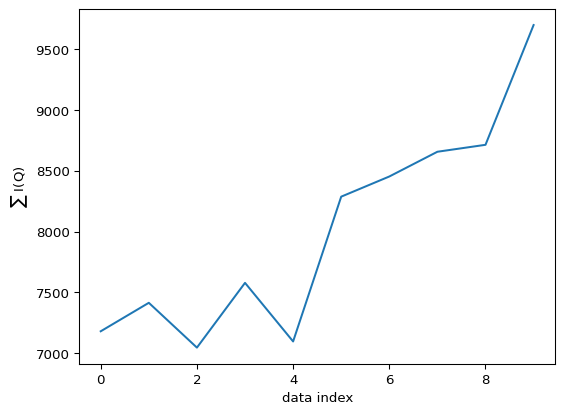

In [28]:
plt.figure()
plt.plot(reduced_data1.sum(axis=0))

plt.xlabel('data index');
plt.ylabel('$\sum$ I(Q)');

**We see there is a slowly rising background, which is why our average was corrupted.  What is happening?**

Unfortunately, just like some of our real detectors, this simulated detector has a slowly varying background.  We need to refresh our dark more frequently to account for this!

Here, we will write a custom plan which takes advantage of our previous `dark_light_collection` plan to perform sequential dark/light measurements, with a built-in kwarg-define sleep time to let the ghost-images fade.  While we're being fancy, we'll also include our data processing function, `process_data`, in the plan to take care of everything in a single step.  We'll append each of those individually reduced dark/light pairs into a new list.

In [29]:
#let detector cool down intially
sim_sleep(60)

#define our new list
new_int_list = []

#define our custom plan
def custom_plan(sample_num, sleep_time = 0, num_loops=1):
    for i in range(num_loops):
        print ('on loop '+str(i))
        this_pair = yield from dark_light_collection(sample_num)
        new_int_list.append(process_data(this_pair))
        sim_sleep(sleep_time)
        
#excecute the plan with the run engine
RE(custom_plan(1, sleep_time = 60, num_loops = 10))

#turn our new intensity list into a numpy array (because I like numpy arrays more than native python lists)
new_int_list = np.array(new_int_list).T

sleeping for 60
on loop 0


sleeping for 60
on loop 1


sleeping for 60
on loop 2


sleeping for 60
on loop 3


sleeping for 60
on loop 4


sleeping for 60
on loop 5


sleeping for 60
on loop 6


sleeping for 60
on loop 7


sleeping for 60
on loop 8


sleeping for 60
on loop 9


sleeping for 60


Now compare this to the ideal data

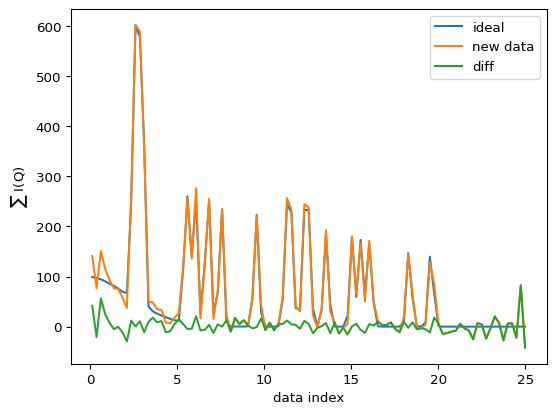

In [30]:
plt.figure()
plt.plot(q, perfect_int1, label='ideal')
plt.plot(q, new_int_list.mean(axis=1),label='new data')
plt.plot(q, new_int_list.mean(axis=1) - perfect_int1, label='diff')

plt.legend()

plt.xlabel('data index');
plt.ylabel('$\sum$ I(Q)');

## Success

  While python and Bluesky can be a bit of a learning-curve at first, they let the beamline staff __and__ users easily develop their own data collection and reduction procedures.  Here, we've just been using a greatl simplified simulated detector, but demonstrated how some of the more tedious aspects of beamline life can be streamlined with Bluesky.